Read two documents and integrate data using 'parent_asin'. Select 11 variables and filter for the "Appliances" category from all classes. Additionally, select only reviews with verified payments to avoid fake reviews.

In [104]:
import pandas as pd

review_df = pd.read_csv("/Users/apple/Desktop/Business Project/data/review.csv")
product_df = pd.read_csv("/Users/apple/Desktop/Business Project/data/product dataset.csv")

In [105]:
# Filter DataFrame for 'Appliances' in 'main_category'
import pandas as pd
filtered_df = product_df[product_df['main_category'] == 'Appliances']
selected_product_columns = ['main_category', 'title', 'average_rating', 'rating_number', 'store', 'parent_asin']
filtered_product_df = filtered_df[selected_product_columns]

selected_review_columns = ['rating', 'title', 'text', 'parent_asin', 'timestamp', 'verified_purchase']
filtered_review_df = review_df[selected_review_columns]

print("Shape before filtering:", filtered_product_df.shape)
print("Shape before filtering:", filtered_review_df.shape)


# Merge the DataFrames on 'parent_asin'
merged_df = filtered_review_df.merge(filtered_product_df, on='parent_asin', how='inner')


# Select 2013-2023 range
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], unit='ms')
start_date = '2013-01-01'
end_date = '2023-12-31'
filtered_df = merged_df[(merged_df['timestamp'] >= start_date) & (merged_df['timestamp'] <= end_date)]

verified_review = filtered_df[filtered_df['verified_purchase'] == True]
# Output the shape of the DataFrame after filtering
print("Shape after filtering:", verified_review.shape)

print(verified_review)

Shape before filtering: (25572, 6)
Shape before filtering: (2128605, 6)
Shape after filtering: (548426, 11)
        rating                                            title_x  \
0          5.0                                         Five Stars   
1          5.0  My old door hinge broke. This worked perfectly...   
2          5.0       Perfect fit and repair for our LG dryer door   
3          5.0                         Perfect match for DLE0442W   
4          5.0                                          Fit fine.   
...        ...                                                ...   
588771     3.0                                   Misleading photo   
588772     1.0                                       Doesn't work   
588774     1.0                                 Item was defective   
588776     5.0                          Fits properly, thank you!   
588777     5.0                                         Five Stars   

                                                     text paren

In [106]:
!pip install pandas scikit-learn nltk
!pip install sentence_transformers numpy


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


Data praparing

In [103]:

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download


def preprocess_sentence(sentence):
    # Ensure the input is a string
    sentence = str(sentence)

    # Convert the sentence to lowercase
    sentence = sentence.lower()

    # Remove punctuation
    sentence = re.sub(r'[^\w\s]', '', sentence)

    # Remove non-alphanumeric characters
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)

    # Define stop words
    stop_words = set(stopwords.words('english'))

    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Add additional stop words
    additional_words = {'el', 'ge','la', 'de', 'br','mi','na','que','one','se','lo','en'}
    stop_words.update(additional_words)

    # Remove stop words and perform lemmatization
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in sentence.split() if word not in stop_words])

    # Remove extra whitespace
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    return sentence



verified_review['processed_text'] = verified_review['text'].apply(preprocess_sentence)

print(verified_review)




[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


        rating                                            title_x  \
0          5.0                                         Five Stars   
1          5.0  My old door hinge broke. This worked perfectly...   
2          5.0       Perfect fit and repair for our LG dryer door   
3          5.0                         Perfect match for DLE0442W   
4          5.0                                          Fit fine.   
...        ...                                                ...   
588771     3.0                                   Misleading photo   
588772     1.0                                       Doesn't work   
588774     1.0                                 Item was defective   
588776     5.0                          Fits properly, thank you!   
588777     5.0                                         Five Stars   

                                                     text parent_asin  \
0         Part came quickly and fit my LG dryer.  Thanks!  B00AF7WZTM   
1       My old door hinge

Topic model Method 1

In [ ]:
# Method 1 TF-IDF + LDA  + SBERT
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=5)
tfidf = tfidf_vectorizer.fit_transform(verified_review['processed_text'])

# Fit the LDA model
n_components = 7  # Assume extracting 7 topics
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20, random_state=42)
lda.fit(tfidf)

# Extract keywords for each topic
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topics

no_top_words = 15
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
topics = display_topics(lda, tfidf_feature_names, no_top_words)

# Convert extracted keywords to DataFrame
topics_df = pd.DataFrame(topics)

# Print extracted keywords
print(topics_df)

# Or display the extracted keywords DataFrame
topics_df





            0        1        2            3        4        5          6
0        easy     part     love          fit      ice     nice      great
1     install  plastic  clothes      perfect    water     look       work
2      worked    screw  machine    perfectly     make     hood       good
3       dryer     door   washer        stove    maker    great    product
4        part   filter    small  replacement    month  freezer      price
5       great      fit      use     original   filter    light     filter
6     working    would     wash         work     time      fan        fit
7   perfectly      old      dry         like  machine    quiet       easy
8     problem     work  washing        exact      use     work    install
9        work    dryer    clean         part  working     good       fast
10      fixed      new    dryer         knob     year  kitchen  described
11        new  product     work        match     work     love      value
12        fix      get     load       

,0,1,2,3,4,5,6
0,easy,part,love,fit,ice,nice,great
1,install,plastic,clothes,perfect,water,look,work
2,worked,screw,machine,perfectly,make,hood,good
3,dryer,door,washer,stove,maker,great,product
4,part,filter,small,replacement,month,freezer,price
5,great,fit,use,original,filter,light,filter
6,working,would,wash,work,time,fan,fit
7,perfectly,old,dry,like,machine,quiet,easy
8,problem,work,washing,exact,use,work,install
9,work,dryer,clean,part,working,good,fast


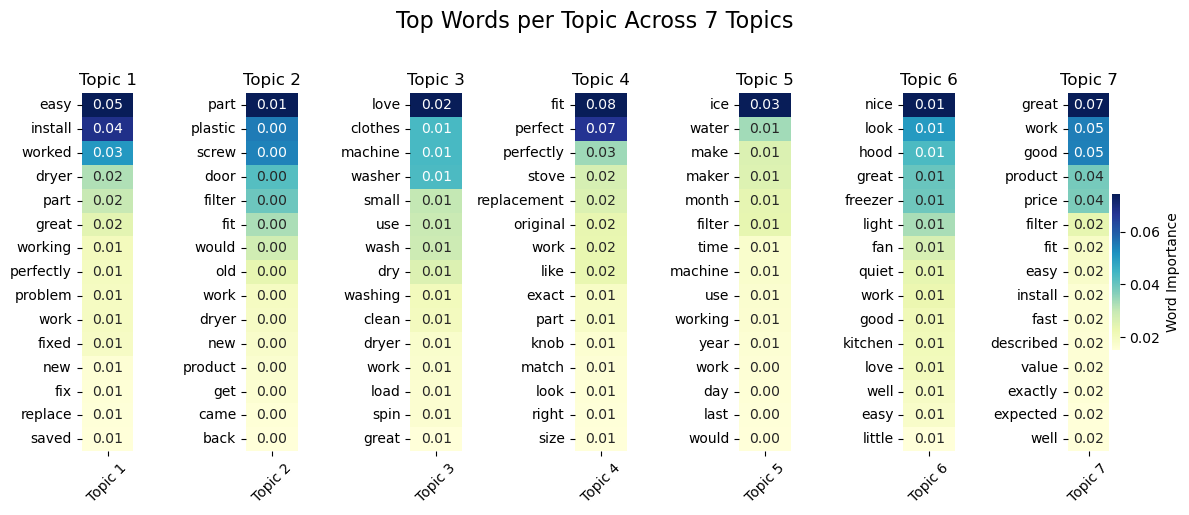

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation




# 提取关键词及其分布
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_word_distribution = np.array([row / row.sum() for row in lda.components_])
num_top_words = 15

# 创建图表和子图，设置为一行多列
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(12, 5))  # 调整子图布局为一行

# 添加总标题
fig.suptitle('Top Words per Topic Across 7 Topics', fontsize=16, y=1.02)  # y参数稍微提高标题，避免与子图重叠

# 对于每个主题，提取数据并绘制热力图
for i in range(7):
    data = {f'Topic {i+1}': topic_word_distribution[i]}
    df = pd.DataFrame(data, index=feature_names)
    df = df.sort_values(by=f'Topic {i+1}', ascending=False).head(num_top_words)

    # 只对最后一个子图添加色彩条
    show_cbar = i == 6  # 只有当 i 等于 6 时，即最后一个主题，才显示色彩条
    ax = sns.heatmap(df, annot=True, fmt=".2f", cmap='YlGnBu', cbar=show_cbar, ax=axes[i])
    axes[i].set_title(f'Topic {i+1}')
    axes[i].tick_params(axis='x', rotation=45)  # 旋转 x 轴标签以便于阅读

    # 如果是最后一个子图，添加图例标签
    if show_cbar:
        cbar = ax.collections[0].colorbar
        cbar.set_label('Word Importance')

# 调整布局以防止标签重叠
plt.tight_layout()
plt.show()

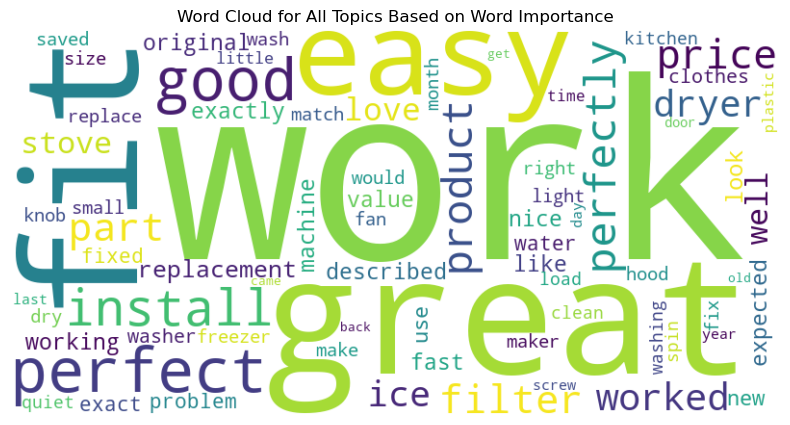

In [ ]:
# WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

# 选择显示每个主题的关键词数量
num_top_words = 15

# 构建包含每个词的总权重的字典
word_weights = {}
for topic_idx, topic in enumerate(topic_word_distribution):
    for i in topic.argsort()[-num_top_words:][::-1]:  # 提取每个主题的前num_top_words个词
        word = feature_names[i]
        weight = topic[i]
        if word in word_weights:
            word_weights[word] += weight  # 如果词已存在，则累加权重
        else:
            word_weights[word] = weight  # 否则，添加词及其权重

# 生成词云
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_weights)

# 显示词云
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for All Topics Based on Word Importance")
plt.axis("off")
plt.show()



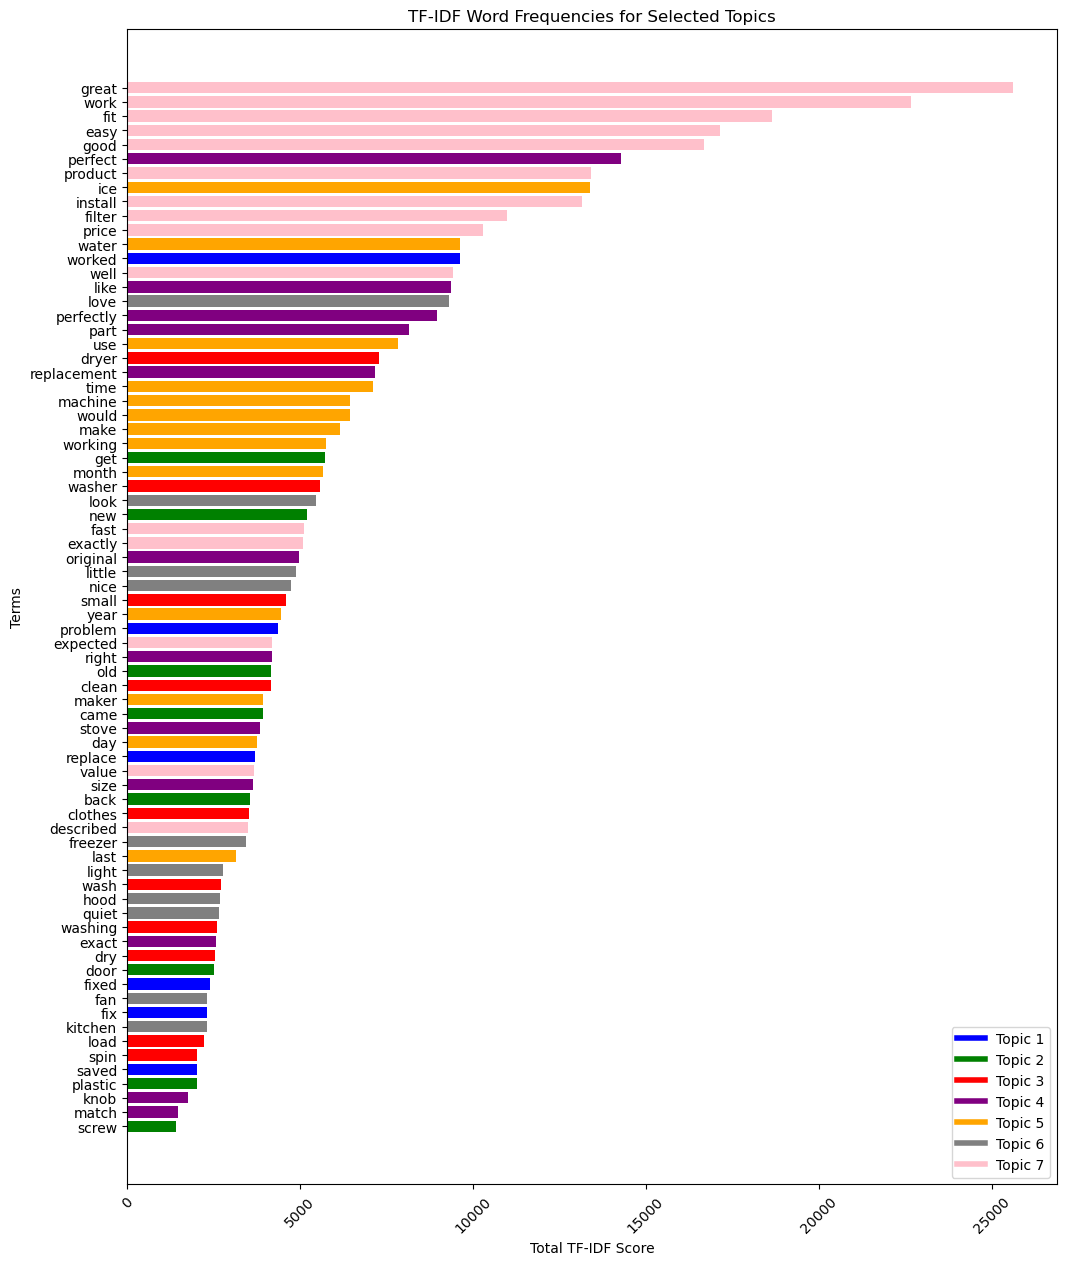

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_tfidf_word_frequency(vectorizer, tfidf_result, topics_df):
    # 计算每个术语在文档中的TF-IDF总和
    sums = tfidf_result.sum(axis=0)
    data = []
    for col, term in enumerate(vectorizer.get_feature_names_out()):
        data.append((term, sums[0, col]))
    ranking = pd.DataFrame(data, columns=['term', 'rank'])
    
    # 提取topics_df中的所有词汇
    terms = topics_df.values.flatten()
    # 过滤出这些词汇的TF-IDF值
    filtered_ranking = ranking[ranking['term'].isin(terms)]
    filtered_ranking = filtered_ranking.sort_values('rank', ascending=False)
    
    # 获取每个词汇所属的主题
    term_topic_mapping = {}
    for topic_idx, topic_terms in topics_df.items():
        for term in topic_terms:
            term_topic_mapping[term] = topic_idx + 1  # 从1开始计数，适应主题编号
    
    filtered_ranking['topic'] = filtered_ranking['term'].map(term_topic_mapping)
    
    # 设置颜色
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'gray', 'pink']
    filtered_ranking['color'] = filtered_ranking['topic'].apply(lambda x: colors[(x-1) % len(colors)])
    
    # 绘制图表
    plt.figure(figsize=(12, 15))
    plt.barh(filtered_ranking['term'], filtered_ranking['rank'], color=filtered_ranking['color'])
    plt.gca().invert_yaxis()  # 将最高值放在顶部
    plt.xticks(rotation=45)
    plt.title("TF-IDF Word Frequencies for Selected Topics")
    plt.xlabel("Total TF-IDF Score")
    plt.ylabel("Terms")
    plt.legend(handles=[plt.Line2D([0], [0], color=colors[i], lw=4, label=f'Topic {i+1}') for i in range(len(topics_df.columns))], loc='lower right')
    plt.show()

# 假设 tfidf_vectorizer 和 tfidf 已经被定义并计算
# 假设 topics_df 是已经提取出来的主题DataFrame
plot_tfidf_word_frequency(tfidf_vectorizer, tfidf, topics_df)


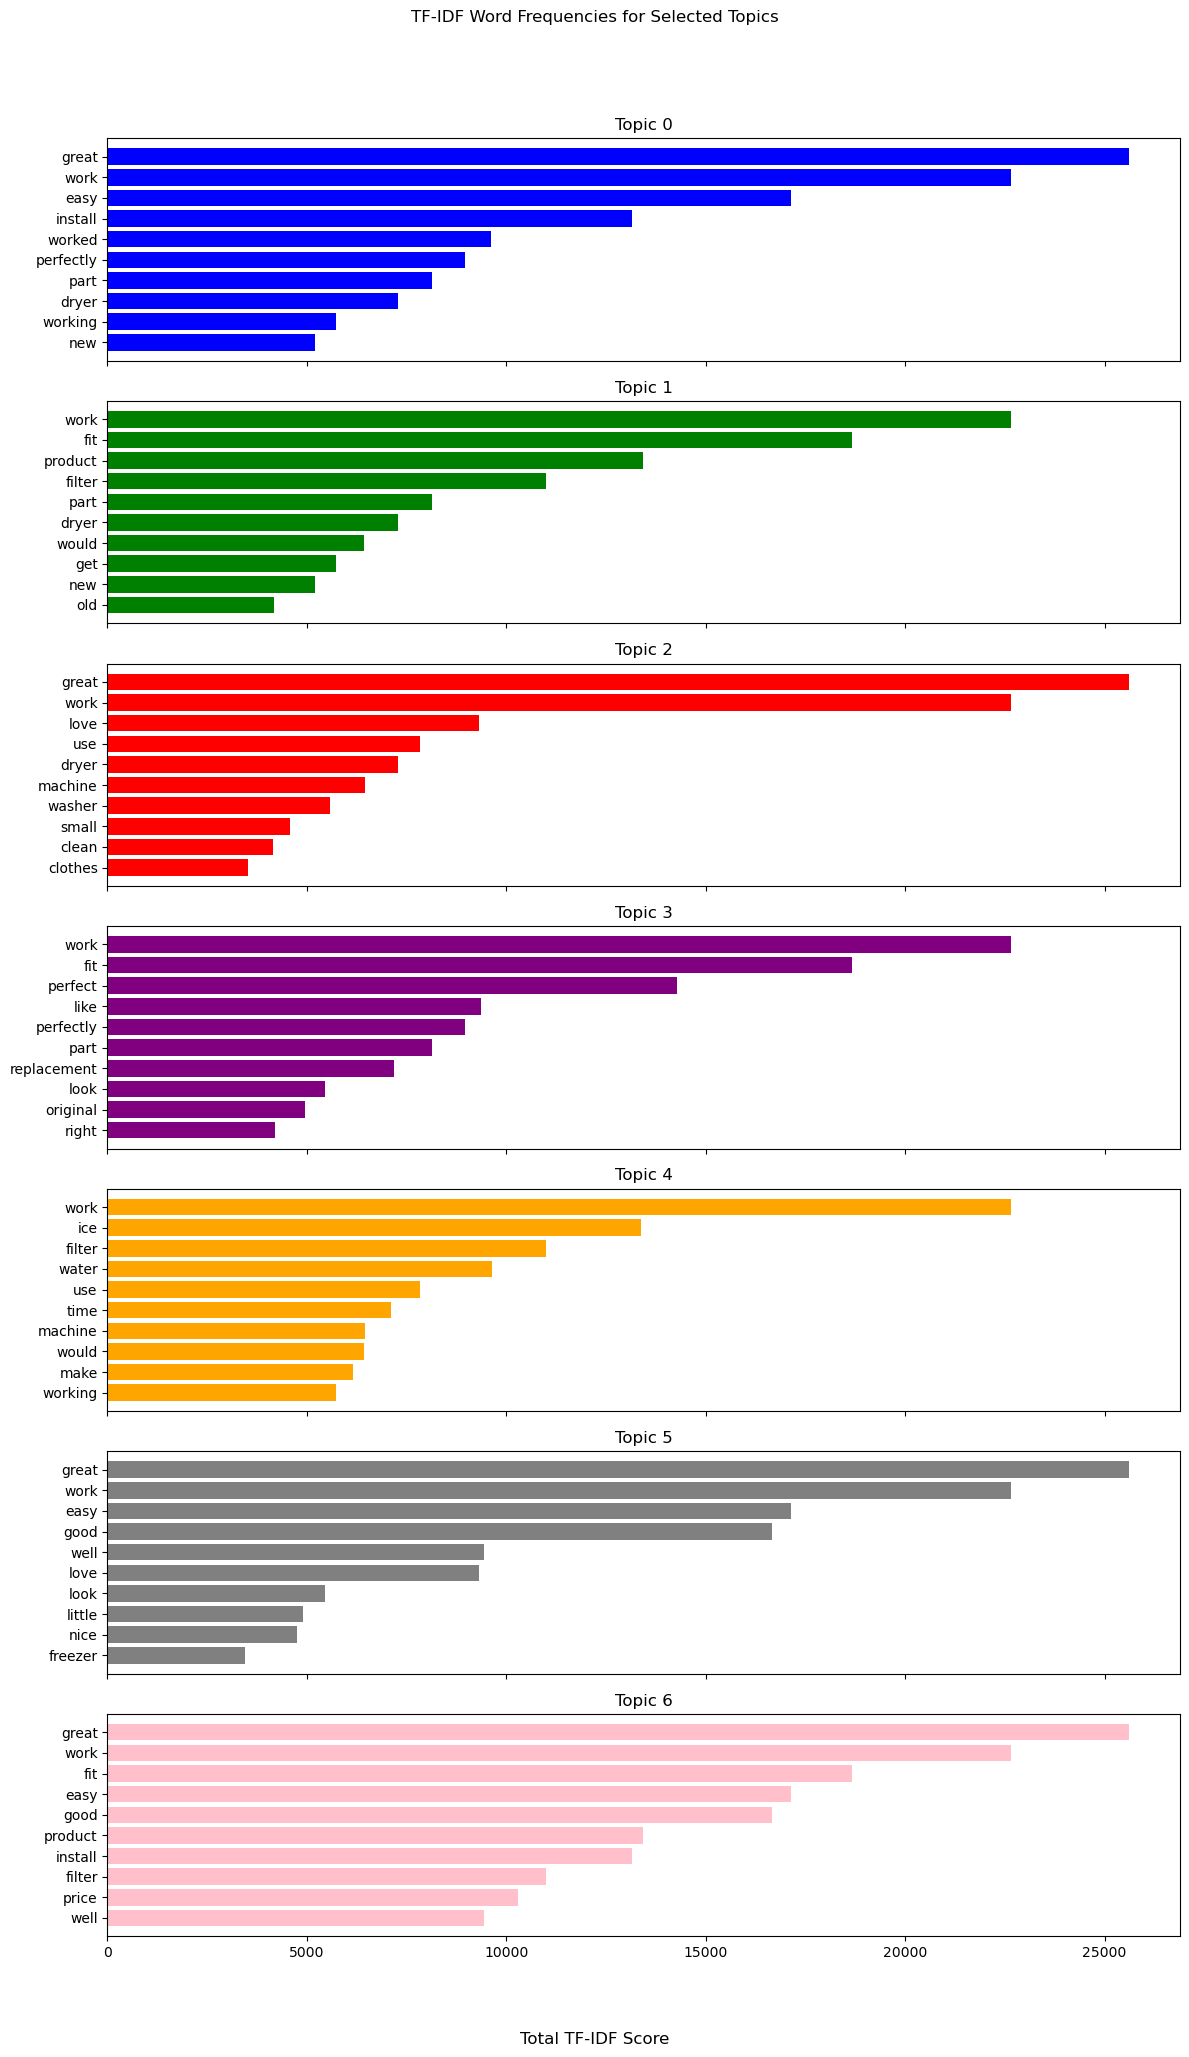

In [ ]:
# 绘制TF-IDF词频图
def plot_tfidf_word_frequency(vectorizer, tfidf_result, topics_df, no_of_terms=10):
    # 计算每个术语在文档中的TF-IDF总和
    sums = tfidf_result.sum(axis=0)
    data = []
    for col, term in enumerate(vectorizer.get_feature_names_out()):
        data.append((term, sums[0, col]))
    ranking = pd.DataFrame(data, columns=['term', 'rank'])
    
    # 分组显示
    colors = ['blue', 'green', 'red', 'purple', 'orange','gray','pink']
    fig, axes = plt.subplots(len(topics_df.columns), 1, figsize=(12, 3 * len(topics_df.columns)), sharex=True)
    if len(topics_df.columns) == 1:
        axes = [axes]
    
    for i, topic in enumerate(topics_df.columns):
        terms = topics_df[topic]
        subset = ranking[ranking['term'].isin(terms)].sort_values('rank', ascending=False)[:no_of_terms]
        axes[i].barh(subset['term'], subset['rank'], color=colors[i % len(colors)])
        axes[i].set_title(f'Topic {i}')
        axes[i].invert_yaxis()
    
    fig.suptitle("TF-IDF Word Frequencies for Selected Topics")
    fig.supxlabel("Total TF-IDF Score")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 假设 tfidf_vectorizer 和 tfidf 已经被定义并计算
plot_tfidf_word_frequency(tfidf_vectorizer, tfidf, topics_df, 10)

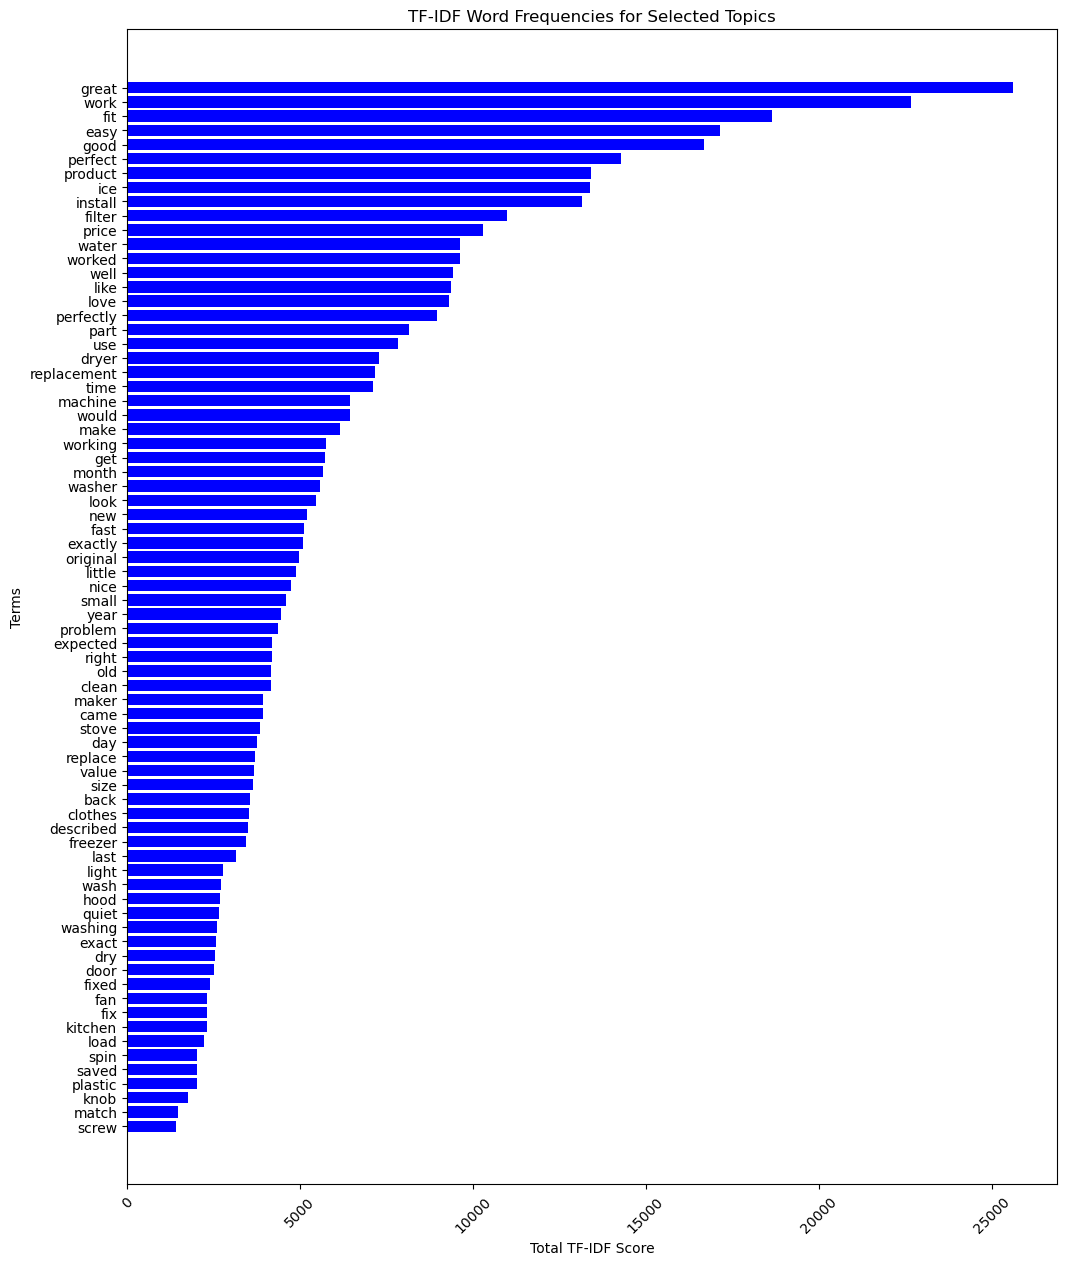

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_tfidf_word_frequency(vectorizer, tfidf_result, topics_df):
    # 计算每个术语在文档中的TF-IDF总和
    sums = tfidf_result.sum(axis=0)
    data = []
    for col, term in enumerate(vectorizer.get_feature_names_out()):
        data.append((term, sums[0, col]))
    ranking = pd.DataFrame(data, columns=['term', 'rank'])
    
    # 提取topics_df中的所有词汇
    terms = topics_df.values.flatten()
    # 过滤出这些词汇的TF-IDF值
    filtered_ranking = ranking[ranking['term'].isin(terms)]
    filtered_ranking = filtered_ranking.sort_values('rank', ascending=False)
    
    # 绘制图表
    plt.figure(figsize=(12, 15))
    plt.barh(filtered_ranking['term'], filtered_ranking['rank'], color='blue')
    plt.gca().invert_yaxis()  # 将最高值放在顶部
    plt.xticks(rotation=45)
    plt.title("TF-IDF Word Frequencies for Selected Topics")
    plt.xlabel("Total TF-IDF Score")
    plt.ylabel("Terms")
    plt.show()

# 假设 tfidf_vectorizer 和 tfidf 已经被定义并计算
plot_tfidf_word_frequency(tfidf_vectorizer, tfidf, topics_df)


In [ ]:
!pip install -U sentence-transformers
!pip install -U scikit-learn


In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Initialize the model
model = SentenceTransformer("all-MiniLM-L6-v2")


characteristics = {
    "durability": ["durability", "broke", "month", "year", "week"],
    "price": ["saved", "money", "value", "price"],
    "install": ["install", "replacement"],
    "service": ["service", "customer"],
    "delivery": ["delivery", "fast", "received"],
    "look": ["design", "look"],
    "fit": ["small", "space", "fit"],
    "advertised": ["described", "advertised"],
    "work": ["use", "work", "working"],
    "emotion": ["love", "perfect", "expected", "excellent"],
    "brand": ["brand"]
}
# Create a list of all characteristic phrases
all_phrases = [phrase for phrases in characteristics.values() for phrase in phrases]


# Compute embeddings for document sentences and characteristic phrases
document_sentences = verified_review['processed_text'].tolist()
document_embeddings = model.encode(document_sentences)
phrase_embeddings = model.encode(all_phrases)

# Compute cosine similarities
similarities = util.pytorch_cos_sim(document_embeddings, phrase_embeddings).numpy()

# Output the pairs with their score
for idx_i, sentence in enumerate(document_sentences):
    print(f"Document Sentence: '{sentence}'")
    for characteristic, phrases in characteristics.items():
        # Get the indices of the phrases corresponding to the current characteristic
        phrase_indices = [all_phrases.index(phrase) for phrase in phrases]
        # Get the maximum similarity score for the current characteristic
        max_similarity = max(similarities[idx_i][phrase_indices])
        print(f" - Characteristic '{characteristic}': {max_similarity:.4f}")
    print()


流式输出内容被截断，只能显示最后 5000 行内容。
 - Characteristic 'delivery': 0.1881
 - Characteristic 'look': 0.1206
 - Characteristic 'fit': 0.2167
 - Characteristic 'advertised': 0.1284
 - Characteristic 'work': 0.2011
 - Characteristic 'emotion': 0.2355
 - Characteristic 'brand': 0.1105

Document Sentence: 'update month later still load every single day love washing machinebr could happier weve portable washing machine way better plastic twin tub build comparable sturdy full size washer small convenience portable wobble spin cycle fully automatic cycle make easy size perfect small family laundry every daysbr live small brooklyn apartment month old parked bathroom hook water included quick attachment whenever need wash set machine cold control water temp faucet knob drain hose hook sinkbr cloth diapering thing better job amana washer previously using love wide selection cycle endless customization washing whatever need hang dry inside apartment proper spacing fan clothes dry within hour allowing easily 

In [ ]:
from transformers import pipeline
from transformers import BertTokenizer

# Initialize sentiment analysis pipeline with a specific model
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Define similarity threshold
similarity_threshold = 0.2

# Collect results in a list
results = []

# Output the pairs with their score and sentiment
for idx, sentence in enumerate(document_sentences):
    print(f"Document Sentence: {sentence}")
    max_similarity = 0
    best_characteristic = None

    for characteristic, phrases in characteristics.items():
        phrase_indices = [all_phrases.index(phrase) for phrase in phrases]
        current_max_similarity = max(similarities[idx, phrase_indices])

        if current_max_similarity > max_similarity:
            max_similarity = current_max_similarity
            best_characteristic = characteristic

    if max_similarity > similarity_threshold:
        # Tokenize the sentence to check its length
        tokens = tokenizer.encode(sentence, truncation=True)


        # Get the sentiment
        sentiment = sentiment_pipeline(sentence)
        sentiment_label = sentiment[0]['label']
        sentiment_score = sentiment[0]['score']

        # Determine the polarity of the sentiment
        if sentiment_label in ['1 star', '2 stars']:
            sentiment_polarity = 'negative'
        elif sentiment_label in ['4 stars', '5 stars']:
            sentiment_polarity = 'positive'
        else:
            sentiment_polarity = 'neutral'

    # Append the results to the list
    results.append({
        'Sentence': sentence,
        'Characteristic': best_characteristic,
        'Characteristic Score': max_similarity,
        'Sentiment Polarity': sentiment_polarity,
        'Stars': sentiment_label,
        'Sentiment Score': sentiment_score
    })

# Convert the results list to a DataFrame
final_data = pd.DataFrame(results)

#print(f" - Characteristic '{best_characteristic}': {max_similarity:.4f}, sentiment polarity: {sentiment_polarity} ({sentiment_label} {sentiment_score:.4f})")


Document Sentence: part came quickly fit lg dryer thanks
Document Sentence: old door hinge broke worked perfectly replacement replacement procedure little involved anticipated made
Document Sentence: second time replaced hinge need learn lean door habr watched video nice know replace easily
Document Sentence: ordered wednesday received friday shipped pennsylvania texas took minute install phillips screwdriver including cleaning year lint old gasketbr sure save reuse plastic bushing old hinge pin
Document Sentence: wish little le expensive made good steel
Document Sentence: quick ship trick
Document Sentence: eeceive timely correct part dryer
Document Sentence: took minute install fixed problem
Document Sentence: perfect fit mybr lg dryerbr partelabr save old screw washer
Document Sentence: easy install fit exactly part replaced door stay close dryer run way cheaper fix calling repairman
Document Sentence: far good fit like glove
Document Sentence: took lot picture phone taking apart lo

In [ ]:
verified_review = verified_review.reset_index(drop=True)
final_data = final_data.reset_index(drop=True)
df_all = pd.concat([verified_review, final_data], axis=1)

In [ ]:
df_all

,rating,title_x,text,parent_asin,timestamp,verified_purchase,main_category,title_y,average_rating,rating_number,store,processed_text,Sentence,Characteristic,Characteristic Score,Sentiment Polarity,Stars,Sentiment Score
0,5.0,Five Stars,Part came quickly and fit my LG dryer. Thanks!,B00AF7WZTM,1480334300000,True,Appliances,LG 4774EL2001A Genuine OEM Door Hinge for LG D...,4.6,129,LG,part came quickly fit lg dryer thanks,part came quickly fit lg dryer thanks,fit,0.239699,positive,5 stars,0.456638
1,5.0,My old door hinge broke. This worked perfectly...,My old door hinge broke. This worked perfectl...,B00AF7WZTM,1489840805000,True,Appliances,LG 4774EL2001A Genuine OEM Door Hinge for LG D...,4.6,129,LG,old door hinge broke worked perfectly replacem...,old door hinge broke worked perfectly replacem...,durability,0.372556,positive,4 stars,0.301445
2,5.0,Perfect fit and repair for our LG dryer door,This is the second time we have replaced this ...,B00AF7WZTM,1604437165969,True,Appliances,LG 4774EL2001A Genuine OEM Door Hinge for LG D...,4.6,129,LG,second time replaced hinge need learn lean doo...,second time replaced hinge need learn lean doo...,install,0.359508,positive,5 stars,0.269364
3,5.0,Perfect match for DLE0442W,"Ordered Wednesday, received Friday (shipped fr...",B00AF7WZTM,1532734516226,True,Appliances,LG 4774EL2001A Genuine OEM Door Hinge for LG D...,4.6,129,LG,ordered wednesday received friday shipped penn...,ordered wednesday received friday shipped penn...,delivery,0.321824,negative,1 star,0.452915
4,5.0,Fit fine.,Wish it was a little less expensive and made o...,B00AF7WZTM,1560356221652,True,Appliances,LG 4774EL2001A Genuine OEM Door Hinge for LG D...,4.6,129,LG,wish little le expensive made good steel,wish little le expensive made good steel,price,0.275827,positive,4 stars,0.391500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5.0,Works Great,Actual human doing human things over here.<br ...,B09W5PMK5X,1664225196894,True,Appliances,COMFEE’ Washing Machine 2.4 Cu.ft LED Portable...,3.5,35,COMFEE',actual human human thing herebr fit everything...,actual human human thing herebr fit everything...,fit,0.311265,positive,5 stars,0.336486
496,5.0,Works great,Works great for my rv,B09W5PMK5X,1648760116146,True,Appliances,COMFEE’ Washing Machine 2.4 Cu.ft LED Portable...,3.5,35,COMFEE',work great rv,work great rv,work,0.375593,positive,5 stars,0.657385
497,3.0,Dented.,The fact that it came all dented i should get ...,B09W5PMK5X,1603820365090,True,Appliances,COMFEE’ Washing Machine 2.4 Cu.ft LED Portable...,3.5,35,COMFEE',fact came dented get half money back fustratin...,fact came dented get half money back fustratin...,durability,0.421881,negative,1 star,0.851128
498,5.0,Buy a dolly for it,This thing is a TROOPER. Super reliable and ca...,B09W5PMK5X,1622461724725,True,Appliances,COMFEE’ Washing Machine 2.4 Cu.ft LED Portable...,3.5,35,COMFEE',thing trooper super reliable countless load,thing trooper super reliable countless load,durability,0.358666,positive,5 stars,0.759774


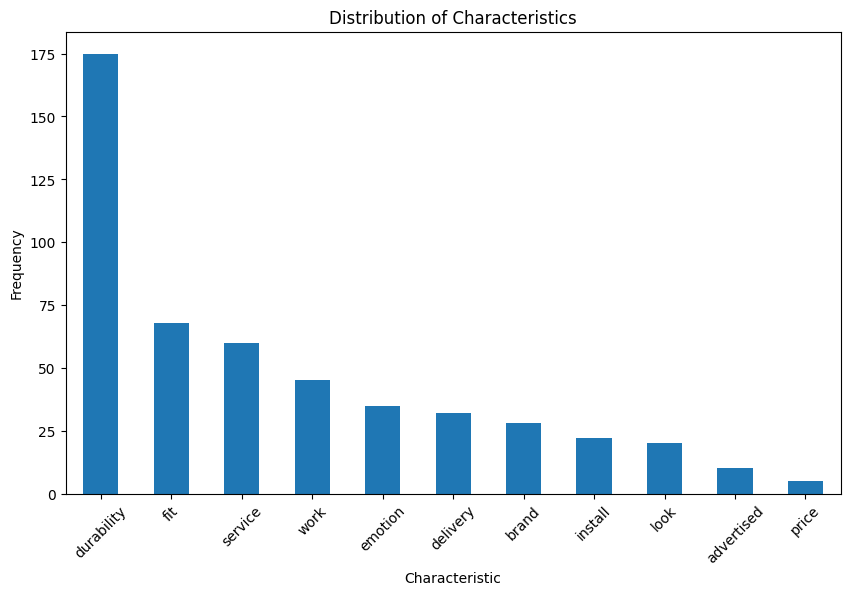

In [ ]:
# Plot 1: Distribution of Characteristics
plt.figure(figsize=(10, 6))
df_all['Characteristic'].value_counts().plot(kind='bar')
plt.title('Distribution of Characteristics')
plt.xlabel('Characteristic')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

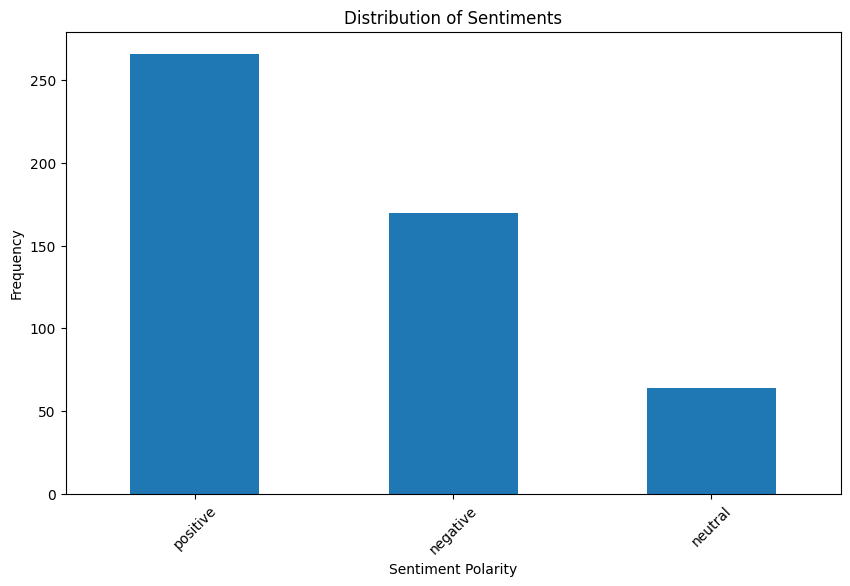

In [ ]:
# sentiment plot
plt.figure(figsize=(10, 6))
df_all['Sentiment Polarity'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

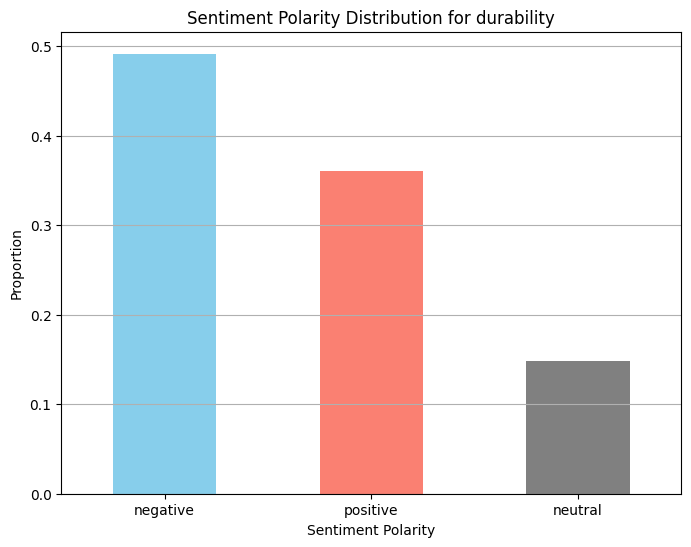

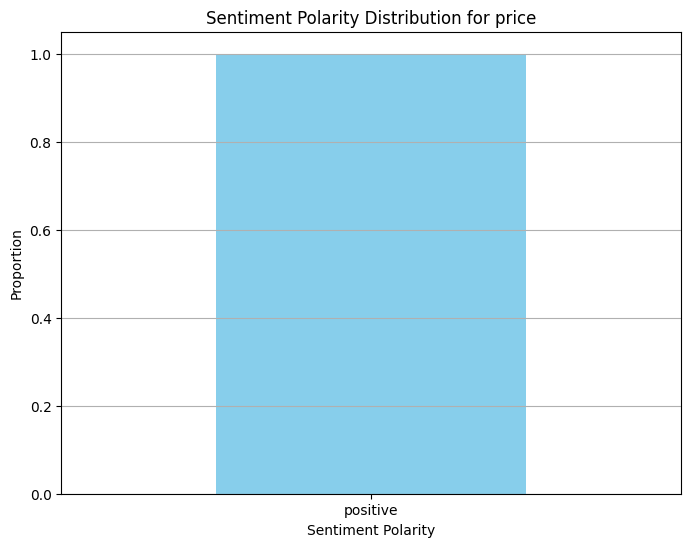

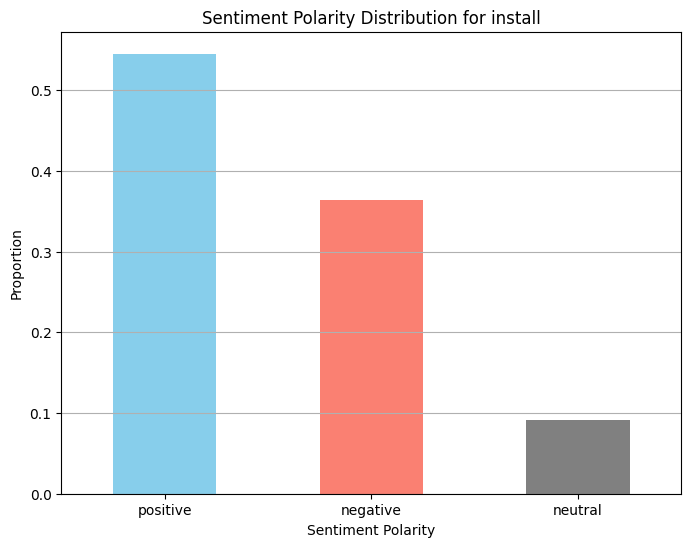

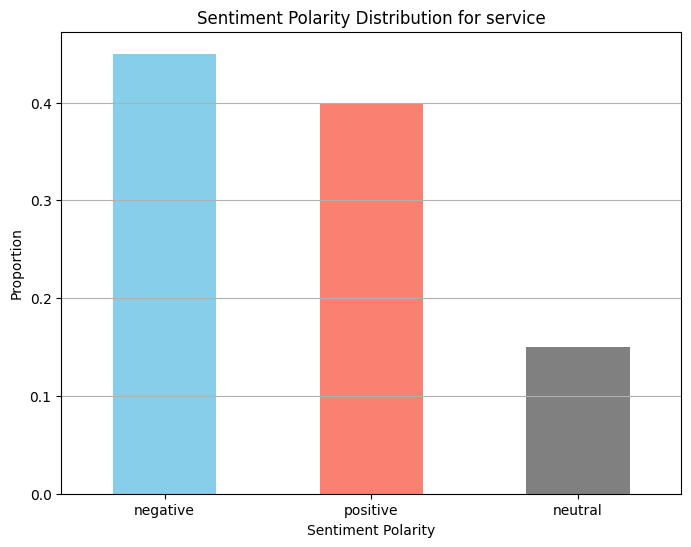

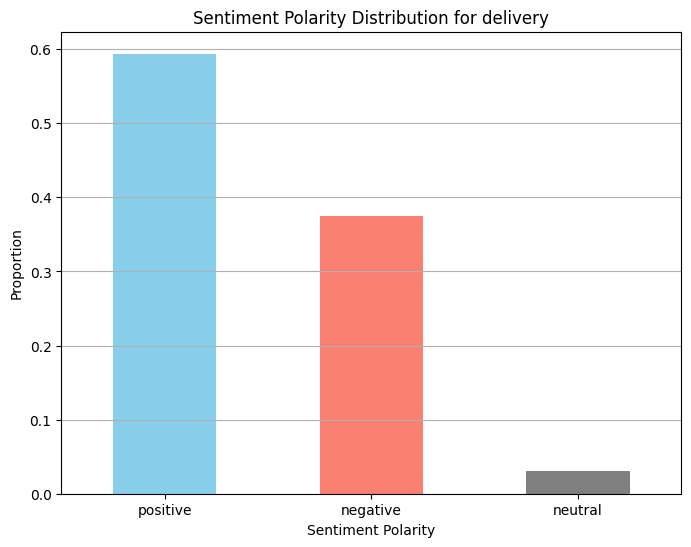

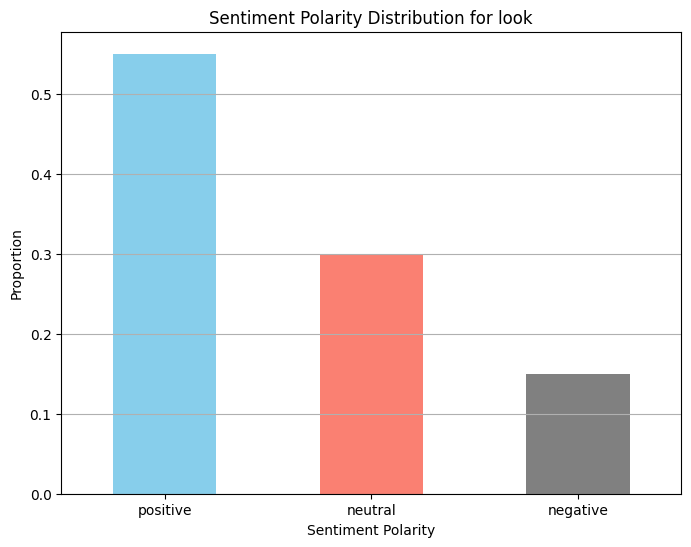

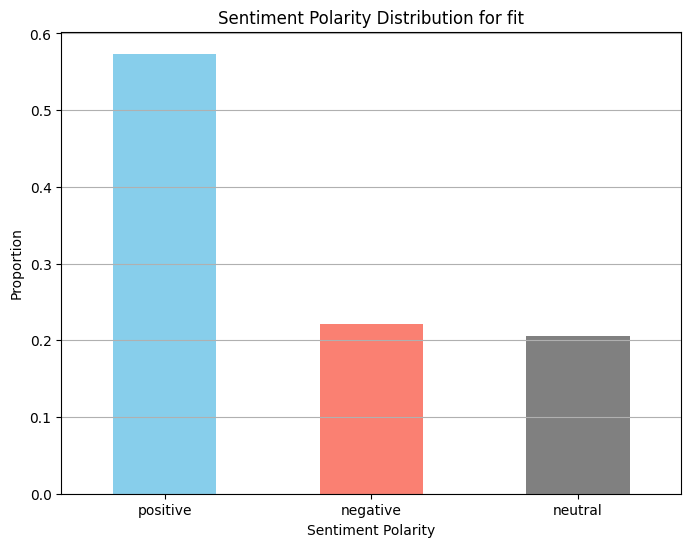

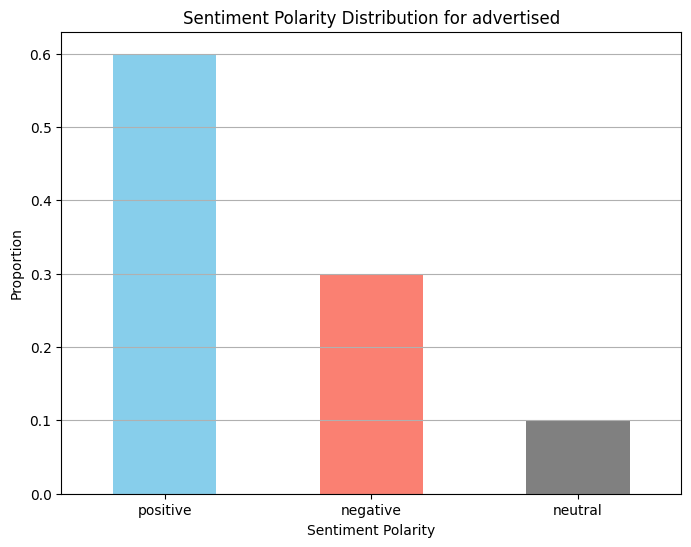

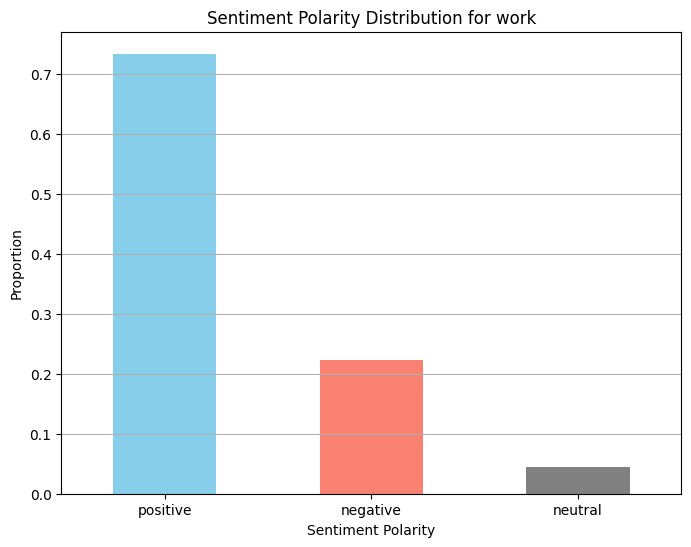

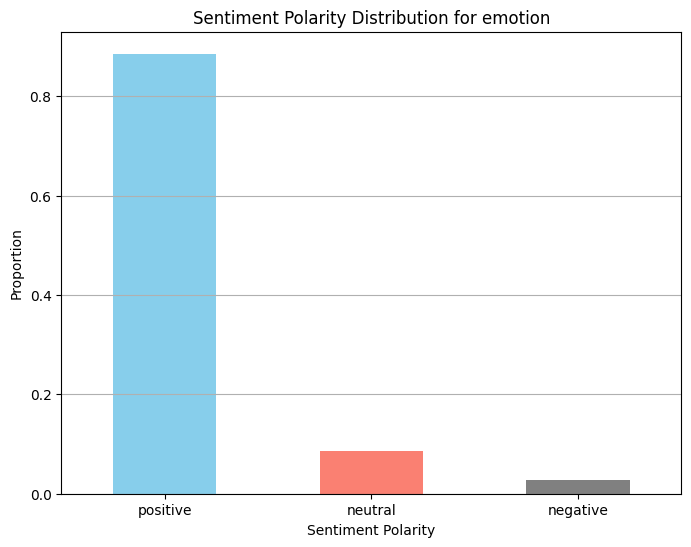

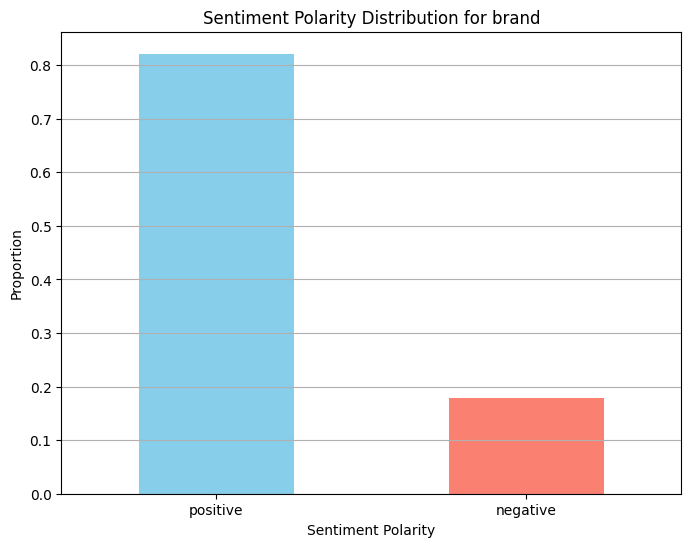

In [ ]:
# each Characteristic
haracteristics = df_all['Characteristic'].unique()

for characteristic in characteristics:
    subset = df_all[df_all['Characteristic'] == characteristic]
    sentiment_distribution = subset['Sentiment Polarity'].value_counts(normalize=True)

    plt.figure(figsize=(8, 6))
    sentiment_distribution.plot(kind='bar', color=['skyblue', 'salmon', 'gray'])
    plt.title(f'Sentiment Polarity Distribution for {characteristic}')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

    plt.savefig(f'sentiment_distribution_{characteristic}.png')
    plt.show()